In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import json

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import metrics

# Load ultimate_data_challenge.json as DataFrame
with open('ultimate_data_challenge.json') as datafile:
    data = json.load(datafile)
df = pd.DataFrame(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [2]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [3]:
# Drop rows with null values
df.dropna(inplace=True)

# Show the first 5 rows sorted by the latest trip date
df.sort_values(by='last_trip_date',ascending=False).head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
24275,King's Landing,7,2014-01-08,4.8,1.00,2014-07-01,iPhone,0.0,True,67.6,2.17,4.7
23681,Astapor,5,2014-01-21,3.1,1.02,2014-07-01,iPhone,7.1,True,75.0,3.14,4.4
4385,King's Landing,0,2014-01-06,4.6,1.08,2014-07-01,iPhone,13.9,True,77.8,2.58,4.7
45155,Winterfell,3,2014-01-28,4.8,1.03,2014-07-01,iPhone,5.7,False,66.0,5.24,4.6
38661,Winterfell,4,2014-01-18,4.4,1.16,2014-07-01,iPhone,28.1,False,65.6,4.07,4.7


In [4]:
def city_num(x):
    if x == "King's Landing":
        x = 1
    elif x == "Astapor":
        x = 2
    else:
        x = 3
    return x

df['city_num'] = df['city'].apply(city_num)

# Change data types for "signup_date" and "last_trip_date" columns to DateTime values
df.signup_date = pd.to_datetime(df.signup_date)
df.last_trip_date = pd.to_datetime(df.last_trip_date)

# Create new column to define if a user is "active" (i.e. 1 for "last_trip_date" within 
# the last 30 days of the user's last trip date, 0 otherwise)
latest = df.last_trip_date.max()
df['IsActiveUser'] = df.last_trip_date.apply(lambda x: 1 if ((latest - x) > datetime.timedelta(days=30))  else 0)

# Create new column to convert "phone" column to boolean (i.e. 1 for iPhone, 0 for Android)
df['phone_bool'] = df.phone.apply(lambda x: 1 if x == "iPhone" else 0)

# Create new column to convert "ultimate_black_user_bool" column to boolean (i.e. 1 for True, 0 for False)
df['ultimate_black_user_bool'] = df.ultimate_black_user.apply(lambda x: 1 if x == True else 0)

# Create new column to determine time difference of "last_trip_date" and "signup_date" in days
# df['time_diff_in_days'] = df.last_trip_date - df.signup_date
# df['time_diff_in_days'] = df['time_diff_in_days'].dt.days

# Create new column to determine the month of "last_trip_date"
df['month_last_trip'] = df.last_trip_date.dt.month

# Create new column to determine the day of "last_trip_date"
df['day_last_trip'] = df.last_trip_date.dt.dayofweek

In [5]:
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_num,IsActiveUser,phone_bool,ultimate_black_user_bool,month_last_trip,day_last_trip
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1,0,1,1,6,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,2,1,0,0,5,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,2,1,1,0,1,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1,0,1,1,6,6
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,3,1,0,0,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,Astapor,3,2014-01-03,4.8,1.11,2014-07-01,iPhone,11.1,True,55.6,2.53,4.7,2,0,1,1,7,1
49994,Astapor,1,2014-01-03,4.6,1.44,2014-05-31,iPhone,37.5,False,25.0,2.25,4.5,2,1,1,0,5,5
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,1,0,1,0,6,3
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,3,1,0,1,5,3


In [6]:
# Define X and y data sets
X = df[['city_num', 'trips_in_first_30_days','avg_rating_of_driver',
       'avg_rating_by_driver','avg_surge', 'surge_pct',
        'weekday_pct', 'avg_dist','ultimate_black_user_bool']]

y = df['IsActiveUser']

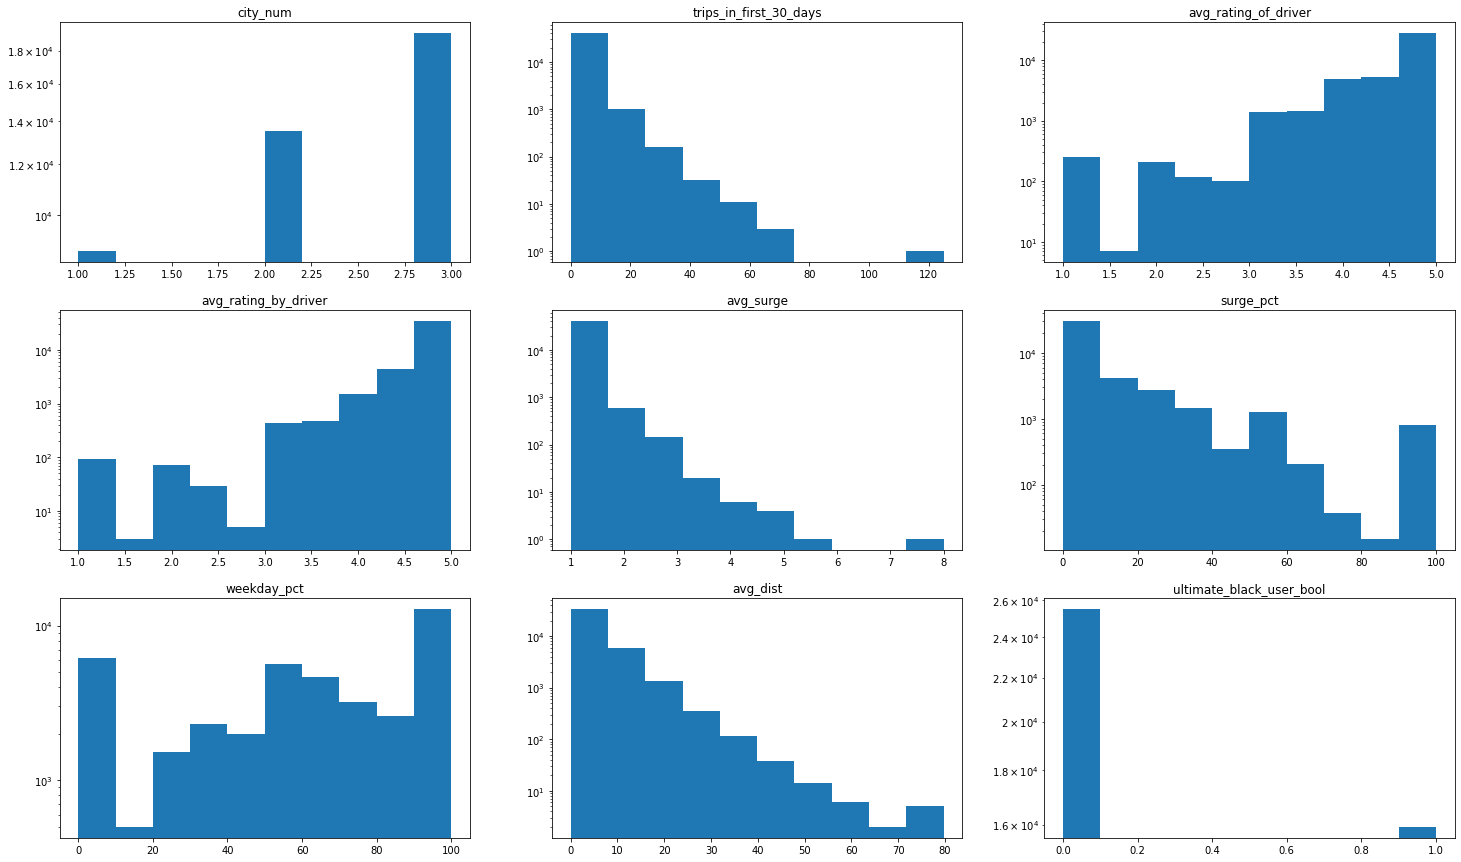

In [8]:
fig,i = plt.subplots(3,3,figsize=(25,15))
n = 0
for a in range(3):
    for b in range(3):
        i[a][b].hist(X.iloc[:,n],log=True)
        i[a][b].set_title(X.columns[n])
        n += 1

plt.show()

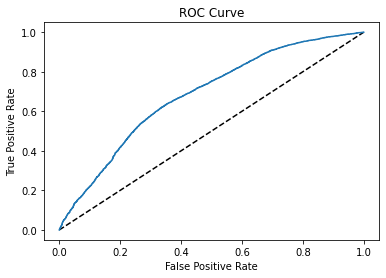

In [9]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Create the classifier: logreg
lr = LogisticRegression()

# Setup the parameters and distributions to sample from: param_dist
param_dist = {'solver':['newton-cg', 'lbfgs'],
              'n_jobs':[4,5,6],
              'max_iter':[900,1000,1100]}

# Instantiate the RandomizedSearchCV object: tree_cv
logreg = RandomizedSearchCV(lr, param_dist, cv=5)

# Fit the classifier to the training data
logreg.fit(X_train,y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(X_test)

# Compute predicted probabilities: y_pred_prob
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [10]:
auc = metrics.roc_auc_score(y_test, y_pred_prob)
auc

0.6835954053993575

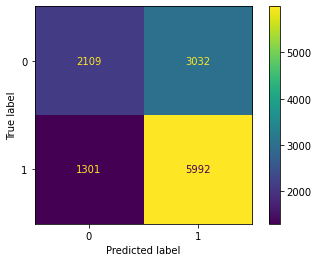

In [11]:
plot_confusion_matrix(logreg, X_test, y_test)  

In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.41      0.49      5141
           1       0.66      0.82      0.73      7293

    accuracy                           0.65     12434
   macro avg       0.64      0.62      0.61     12434
weighted avg       0.65      0.65      0.63     12434



In [13]:
# Approx 59% of riders are retained as Active
(df[df.IsActiveUser == 1].shape[0])/(df.shape[0])

0.5889733381590059

In [14]:
logreg.best_params_

{'solver': 'lbfgs', 'n_jobs': 5, 'max_iter': 1100}

In [15]:
model = LogisticRegression(solver = 'newton-cg', 
                           n_jobs = 4, 
                           max_iter = 900)

model.fit(X_train,y_train)

feature_importances = pd.DataFrame(model.coef_[0],
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)
feature_importances['average']= df[df.IsActiveUser == 1].mean()
feature_importances

,importance,average
city_num,0.467018,2.354445
avg_surge,0.347269,1.074517
avg_rating_by_driver,0.200036,4.788181
avg_rating_of_driver,0.069132,4.607808
avg_dist,0.033194,5.844723
weekday_pct,0.000310,60.951770
surge_pct,-0.004538,8.728419
trips_in_first_30_days,-0.115387,1.935477
ultimate_black_user_bool,-0.866015,0.295780


In [16]:
x = sum(feature_importances['average'] * feature_importances['importance']) + (-0.213832 * 180)
1 / (1 + np.exp(-x))

2.2133466848635794e-16

In [17]:
x

-36.04685578078481